In [3]:
import re
import os
import pandas as pd
!pip install PyPDF2
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
pdf_files = ['/content/acr_fatg.pdf','/content/altdev.pdf', '/content/animal.pdf', '/content/cabin_fumes.pdf', '/content/chklist.pdf', '/content/ctlr.pdf', '/content/fuel.pdf', '/content/mechanic.pdf', '/content/nmac.pdf', '/content/wx.pdf']

In [5]:
def parse_aviation_pdfs(file_list):
    extracted_data = []

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        label = os.path.splitext(file_name)[0]

        try:
            reader = PdfReader(file_path)
            full_text = ""
            for page in reader.pages:
                full_text += page.extract_text()


            pattern = r"Narrative:\s*\d+(.*?)(?:Synopsis|ACN:|Narrative:\s*\d+|$)"
            matches = re.findall(pattern, full_text, re.DOTALL)

            for narrative in matches:

                clean_text = narrative.replace('\n', ' ').strip()

                if len(clean_text) > 50:
                    extracted_data.append({
                        'text': clean_text,
                        'event_type': label
                    })

            print(f"Successfully processed {file_name}: Found {len(matches)} narratives.")

        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return pd.DataFrame(extracted_data)


df = parse_aviation_pdfs(pdf_files)


if df.empty:
    print("No data extracted. Please check your file paths.")
else:
    print(f"\nTotal records extracted: {len(df)}")
    print(df.head())

Successfully processed acr_fatg.pdf: Found 51 narratives.
Successfully processed altdev.pdf: Found 50 narratives.
Successfully processed animal.pdf: Found 51 narratives.
Successfully processed cabin_fumes.pdf: Found 59 narratives.
Successfully processed chklist.pdf: Found 50 narratives.
Successfully processed ctlr.pdf: Found 51 narratives.
Successfully processed fuel.pdf: Found 51 narratives.
Successfully processed mechanic.pdf: Found 54 narratives.
Successfully processed nmac.pdf: Found 52 narratives.
Successfully processed wx.pdf: Found 52 narratives.

Total records extracted: 521
                                                text event_type
0  On approach into ROA, while turning base to fi...   acr_fatg
1  Aircraft X ZZZZ divert sequence of events: XA:...   acr_fatg
2  At XD:38, in cruise FL280, the secondary engin...   acr_fatg
3  After a long day of delays into and out of ZZZ...   acr_fatg
4  It was the go home leg of a three day trip. I ...   acr_fatg


In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

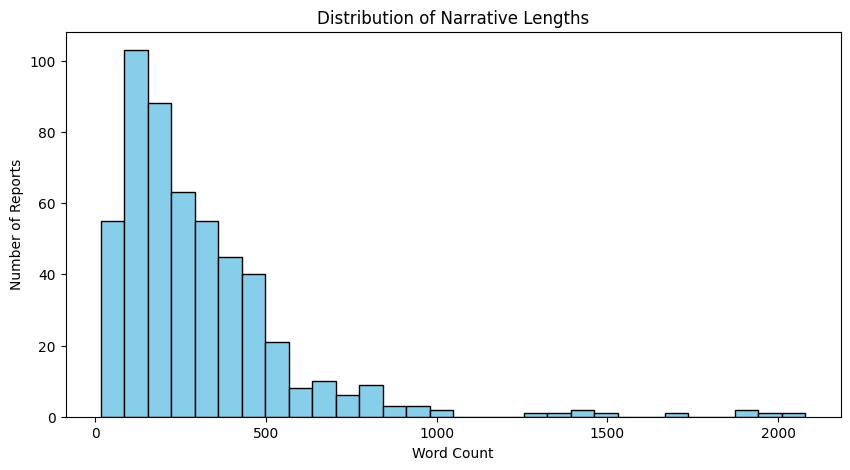

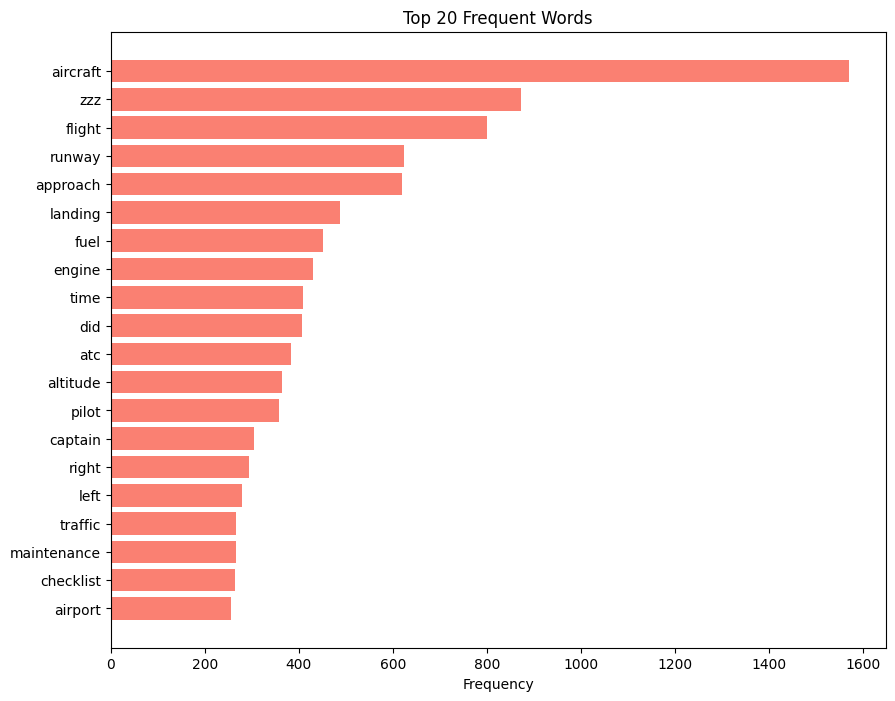

In [7]:
def visualize_data(dataframe):
    if dataframe.empty:
        print("No data to visualize.")
        return


    dataframe['word_count'] = dataframe['text'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 5))
    plt.hist(dataframe['word_count'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Narrative Lengths')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Reports')
    plt.show()


    all_text = ' '.join(dataframe['text']).lower()
    clean_text = re.sub(r'[^a-z\s]', '', all_text) # Keep only letters
    words = clean_text.split()


    filtered_words = [w for w in words if w not in ENGLISH_STOP_WORDS and len(w) > 2]


    common_words = Counter(filtered_words).most_common(20)
    words_x, counts_y = zip(*common_words)

    plt.figure(figsize=(10, 8))
    plt.barh(words_x, counts_y, color='salmon')
    plt.gca().invert_yaxis()
    plt.title('Top 20 Frequent Words')
    plt.xlabel('Frequency')
    plt.show()


visualize_data(df)

In [8]:
if not df.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'],
        df['event_type'],
        test_size=0.2,
        random_state=42
    )

In [9]:
model = make_pipeline(
        TfidfVectorizer(stop_words='english', max_features=5000),
        LinearSVC(random_state=42, dual='auto')
    )

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('linearsvc', LinearSVC(random_state=42))])

In [11]:
predictions = model.predict(X_test)

In [12]:
print("\nModel Performance Report:")
print(classification_report(y_test, predictions))


Model Performance Report:
              precision    recall  f1-score   support

    acr_fatg       0.80      0.67      0.73        12
      altdev       0.50      0.38      0.43        16
      animal       0.60      0.67      0.63         9
 cabin_fumes       0.92      1.00      0.96        11
     chklist       0.80      0.36      0.50        11
        ctlr       0.90      1.00      0.95         9
        fuel       0.70      0.88      0.78         8
    mechanic       0.80      1.00      0.89         8
        nmac       0.46      1.00      0.63         6
          wx       0.69      0.60      0.64        15

    accuracy                           0.70       105
   macro avg       0.72      0.75      0.71       105
weighted avg       0.72      0.70      0.69       105



In [13]:
def predict_event(new_text):
    if df.empty:
        return "Model not trained."

    prediction = model.predict([new_text])[0]
    return prediction

In [14]:
input_narrative = input("Enter the narrative :")
result = predict_event(input_narrative)
print(f"PREDICTED EVENT TYPE: {result}")

Enter the narrative :I was climbing to 3000 feet when I saw traffic at 12 o'clock.  The other aircraft passed 100 feet below me. I took evasive action  and banked right. No radio contact was made.
PREDICTED EVENT TYPE: nmac
